Introduction
===

In [1]:
import simcompyl as sim

In [2]:
from examples.walk import walk

To show, how to use this libary, here's an example `Model` of a random walk:

- First of all, it defines a basic random `Walk`:
  - It will intialize the position of all samples with 0.
  - The iterate step just calls of the the walk function, doing the actual walk, 
    but other things could be added by sub-classes.
  - The walk step taking random steps in each direction.
    Note that the walk method actually returns the steps helping us with reusing and combing this step.
- A `Sawn` extension will add random initialization to the walk.
- Furthermore, the `Energy` extension keeps track of an energy value for each sample,
  denying steps when the engergy reaches zero.
- These classes can be combined simply by inheritence, like for the `ComplexWalk`
- At last, we also need `Allocation` objects, 
  that define values for the abstract parameters used throught the simulation.
  
Here's the complete code of the module:

In [3]:
%pycat examples/walk/walk.py

"""Small example showing the features of the simulation framework."""

import simcompyl as sim
import numpy as np


class Walk(sim.Model):
    """The Walk model defines the bases for a random walk simulation.

    It take care of initialzing the samples x and y coordinatesand as well as
    calling the `walk` step periodically. This step uses a random distribution
    to get coordinate updates.
    """

    @sim.step
    def init(self):
        """
        Initialize the x and y coordinates of the samples.

        State
        -----
        x : float
            x coordinate of samples
        y : float
            y coordinate of samples
        """
        # bind indieces that can access specific parts of the state
        x = self.state(x=float)
        y = self.state(y=float)

        def impl(params, state):
            state[x] = 0
            state[y] = 0

        return impl

    @sim.step
    def iterate(self):
        """Call the walk method to do the stepping.

        Ste

## Using the model

Now we can initalize an instance of the model and the allocations:

In [4]:
model = walk.ComplexWalk()
alloc = walk.BasicDistance() + walk.Simulation()

INFO:simcompyl.core.alloc:combining allocations BasicDistance() + Simulation()


As the structure of the model is defined with the `step` annotation and resolving is done before the actual call inside the implementation, the model can be inspected without execution:

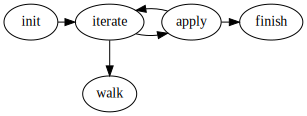

In [ ]:
model.graph(rankdir='TD')

In [ ]:
alloc

BasicDistance():
- Initial energy of individuals: initial_energy=Initial energy of individuals: 1000
- initial x coordinate: initial_x=initial x coordinate: {'loc': 0, 'scale': 1}
- initial y coordinate: initial_y=initial y coordinate: {'loc': 0, 'scale': 1}
- step in x direction: step_x=step in x direction: (-0.1, 0.1)
- step in y direction: step_y=step in y direction: (-0.1, 0.1)
Simulation():
- Number of samples to simulate: n_samples=Number of samples to simulate: 1000
- Count of steps that each individual takes: n_steps=Count of steps that each individual takes: 100

Running the Model
===

To run the definitions inside the model, we create an `Execution` object, that will create optmized code for fast execution. The first execution therefore will take more time, but further executions, even when chaning parameters, will be fast.

In [ ]:
exec = sim.Execution(model, alloc)

In [ ]:
%time out = exec.run()

INFO:simcompyl.core.engine:engine creates parameters numpy array
INFO:simcompyl.core.engine:engine creates layout for parameters.
INFO:simcompyl.core.engine:engine creates state arg


In [ ]:
%time out = exec.run(initial_energy=2000);

In [ ]:
out.head()

This way, one can execute the model with a big sample size in a short amount of time:

In [ ]:
%time out = exec.run(n_steps=500, n_samples=1_000_000)

Tracing our State
===

Another important feature of the simulhave module are traces. 
They help you to inspect statistics of the state during simulation, so you do not only get the state after the simulation did complete, but also can see how the state does develop during the simulation.

Tracing can be done into a simple pandas dataframe, but also into dynamic datastructures, like `holoviews.stream.Buffer` objects, updating plots during simulation:

In [ ]:
import holoviews as hv
hv.extension('bokeh')

In [ ]:
import numpy as np
dist = (model(dist=lambda x, y: np.sqrt(x*x + y*y))
       .take(12)
       .to(sim.trace.Holotrace, batch=500, skip=10, timeout=.2))

In [ ]:
dist.plot(hv.Curve).opts(hv.opts.NdOverlay(width=600, height=300, legend_limit=4))

In [ ]:
%%time
with exec.trace(dist):
    exec.run(n_steps=10_000)

Here's a more complex example, traceing the complete path of 20 individuals, that gets shaded before pushing it to the browser, so the browser does not have to render all the path segments:

In [ ]:
pos = model['x', 'y'].take(20).to(sim.trace.Holotrace, batch=100, timeout=0.02)

In [ ]:
def show(ds):
    if ds.data.trace.iloc[-1] == 0:
        ds = hv.Dataset([[.01, 0, 0], [0, 0, .01]], 
                        kdims=['x', 'sample'], 
                        vdims=['y'])
    else:
        ds = hv.Dataset(ds.data
                        .set_index(['trace', 'sample', 'variable'])
                        .value.unstack(),
                        kdims=['x', 'sample'], 
                        vdims=['y'])
    return ds.to(hv.Path, kdims=['x', 'y'], vdims=[]).overlay()

out = pos.plot(show).opts(width=400, height=400)

In [ ]:
from holoviews.operation.datashader import datashade, spread
import datashader as ds

spread(datashade(out, 
                 aggregator=ds.count_cat('sample'), 
                 height=400, width=400),
       px=1, how='saturate').opts(width=400, height=400)

In [ ]:
%%time
with exec.trace(pos):
    exec.run(n_steps=500)

Outlook
===

This notebook show some of the basic concepts and features, have a look at the documentation to find out more,
for example about
- derived parameters
- different engines
- tracing grammer

Furthermore, features will be added in the future and you're welcome to help the development of this library as well as report back with feedback about it.